# Start

## Testato con immagine library/python:latest

In [ ]:
!pip install -r requirements.txt

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
dateprint = lambda x, form: int(x.strftime(form))

def transformData(df):
    
    # Convert boolean string values to numerics.
    df["No-show"] = df["No-show"].eq("Yes").mul(1)
    df["Gender"] = df["Gender"].eq("M").mul(1)
    
    # Calculate the time between appointment and schedule date.
    # Get them in seconds to use them in the classifier.
    df["AppointmentToScheduleDistance"] = (df.AppointmentDay - df.ScheduledDay).dt.seconds
    
    # Split schedule and appointments to examine possible related patterns with the "No-show" event
    # on specific hours, days of the week or even months. We won't keep the year because forecasting
    # is not in the scope of this task.
    df["ScheduledDayOfWeek"] = df.ScheduledDay.transform(dateprint, form="%w")
    df["AppointmentDayOfWeek"] = df.AppointmentDay.transform(dateprint, form="%w")
    df["ScheduledHour"] = df.ScheduledDay.transform(dateprint, form="%H")
    df["AppointmentHour"] = df.AppointmentDay.transform(dateprint, form="%H")
    df["ScheduledDayOfMonth"] = df.ScheduledDay.transform(dateprint, form="%d")
    df["AppointmentDayOfMonth"] = df.AppointmentDay.transform(dateprint, form="%d")
    df["ScheduledMonth"] = df.ScheduledDay.transform(dateprint, form="%m")
    df["AppointmentMonth"] = df.AppointmentDay.transform(dateprint, form="%m")
    
    # We have done with those...
    df.drop("AppointmentDay", axis=1, inplace=True)
    df.drop("ScheduledDay", axis=1, inplace=True)

    # Those should carry no useful information, we are not superstitious.
    # Let's drop them.
    df.drop("PatientId", axis=1, inplace=True)
    df.drop("AppointmentID", axis=1, inplace=True)
    
    # We could encode this with LabelEncoder + OneHotEncoder, but will make the process
    # much more complex (and resource-eager) with little-to-no benefits.
    df.drop("Neighbourhood", axis=1, inplace=True)


    
    

In [3]:
# Loading data and test files as requested
train_data = pd.read_csv("train.csv", parse_dates=["ScheduledDay", "AppointmentDay"], date_parser=dateparse)
test_data = pd.read_csv("test.csv", parse_dates=["ScheduledDay", "AppointmentDay"], date_parser=dateparse)

# Transforming dataframes
transformData(train_data)
transformData(test_data)

In [4]:
# Splitting dependent and independent features
X_train = train_data.iloc[:,1:].values
y_train = train_data.iloc[:,:1].values.ravel()

X_test = test_data.iloc[:,1:].values
y_test = test_data.iloc[:,:1].values.ravel()

In [5]:
# Time for some decisions! First we train the model, then we test it.
# With max_depth = 7 we get the best results, increasing it will just start to overfit.

# Since we don't know how good a linear boundary will perform with a more extended
# dataset, we choose DecisionTreeClassifier over LogisticRegression, even if performances were really close.

tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.799
Accuracy on test set: 0.799


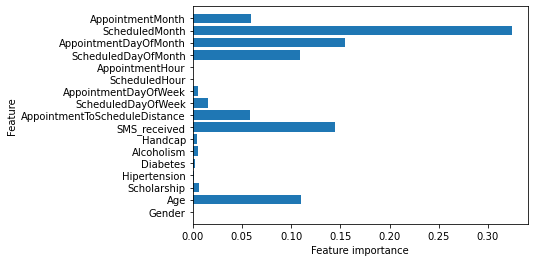

In [6]:
# Let's plot the importance of all independent features, because it's fun!

def plot_feature_importances(model, features):
    n_features = features.size
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree, train_data.columns[1:])

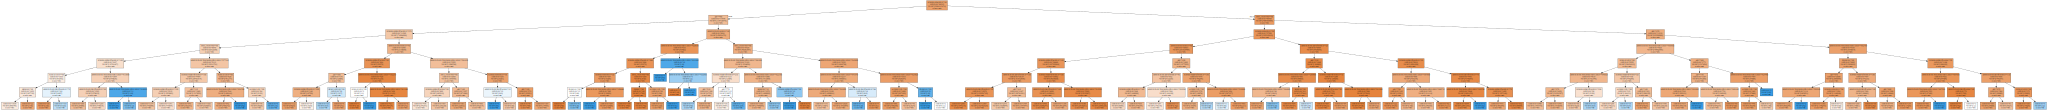

In [7]:
# Let's print the decision tree of the model, because it's fun!

from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["Yes", "No"],
                feature_names=train_data.columns[1:], impurity=False, filled=True, max_depth=7)

import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## END